In [1]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

from dataset import CardiacDataset
from model import UNet

In [2]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
               rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [3]:
train_path = Path('Preprocessed/train')
val_path = Path('Preprocessed/val')

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

In [4]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [5]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred * mask).sum()
        # Add a small number to not divide by 0
        denum = pred.sum() + mask.sum() + 1e-8
        dice = (2 * counter) / denum
        return 1 - dice

In [6]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet().to('cuda:0')

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()

    def forward(self, data):
        return torch.sigmoid(self.model(data))

    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log('Train Dice', loss)

        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), 'Train')

        return loss

    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mri, mask = mri.to('cuda:0'), mask.to('cuda:0')
        mask = mask.float()
        pred = self(mri)
        loss = self.loss_fn(pred, mask)

        self.log('Val Dice', loss)

        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), 'Val')

        return loss

    def log_images(self, mri, pred, mask, name):

        pred = pred > 0.5

        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap='bone')
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)

        axis[1].imshow(mri[0][0], cmap='bone')
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)

        self.logger.experiment.add_figure(name, fig, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [7]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [8]:
checkpoint_callback = ModelCheckpoint(monitor='Val Dice', save_top_k=10, mode='min')

In [9]:
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir='logs'), log_every_n_steps=1,
                     callbacks=checkpoint_callback, max_epochs=45)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
# trainer.fit(model, train_loader, val_loader)

In [11]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera

In [13]:
model = AtriumSegmentation.load_from_checkpoint('Trained-Model.ckpt')

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval();
model.to(device)

AtriumSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2):

In [15]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/339 [00:00<?, ?it/s]

In [16]:
1 - model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))

tensor(0.2123, dtype=torch.float64)

In [17]:
subject = 'Dataset/imagesTs/la_002.nii.gz'
subject_mri = nib.load(subject).get_fdata()

In [18]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized


def standardize(normalized_data):
    standardized = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized

In [19]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [20]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:, :, i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

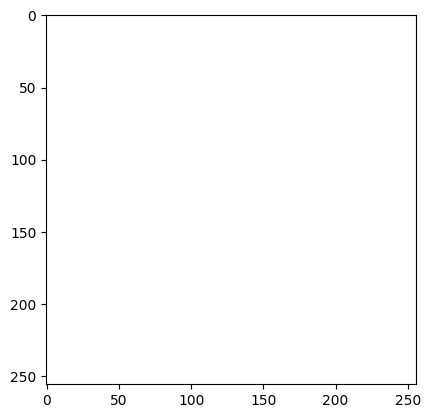

In [21]:
fig = plt.figure()
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:, :, i], cmap='gray')
    mask = np.ma.masked_where(preds[i] == 0, preds[i])
    plt.imshow(mask, alpha=0.5)
    camera.snap()
    
animation = camera.animate()

In [22]:
from IPython.display import HTML
HTML(animation.to_html5_video())